# Preprocesamiento de Datos

El preprocesamiento de datos - a veces también conocido como transformación de datos o, incluso, ingeniería de atributos - es probablemente una de las parte más importante del trabajo del Data Scientist, tal vez la más importante. Como habrás visto en la bitácora, son muchos los pasos involucrados en este proceso, y eso que no los hemos mencionados a todos, pero sí los más importantes. En este notebook, trabajaremos sobre cuatro grandes áreas:

1. Valores Faltantes
2. Valores Atípicos
3. Escalado de Datos
4. Encoders (codificadores)

Si estas explorando datos, mejor usar Pandas. Si estás en un flujo de Machine Learning, Scikit-Learn. Probablemente, termines usando las dos en un mismo notebook.

## 1. Valores Faltantes

En este ejercicio te proveemos de un dataset de seis columnas y 1500 instancias. Salvo una columna, `V1`, todas tienen valores faltantes. De las columnas con valores faltantes:
* Dos tienen valores faltantes MCAR (el valor faltante es completamente al azar y no depende de otras variables)
* Una tiene valores faltantes MAR (la probabilidad de valor faltante depende de otra variable).
* Una tiene valores faltantes MNAR (la probabilidad de valor faltante depende de esa misma variable).

### 1.1 MCAR, MAR o MNAR

El objetivo de esta sección es que analisis el origen de estos valores faltantes. Para ello:

1. Abre los datos y explóralos. Con ese fin, te recomendamos hacer un `pairplot` (con y sin `hue`) de Seaborn y contar los valores faltantes por columna. ¿Qué tipo de datos son?¿Cuáles son sus distribuciones?¿Te parece que hay alguna columna correlacionada con otra?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### DATA CON VF

In [2]:
data = pd.read_csv('Data\DS_Bitácora_19_Data_con_VF.csv')

In [3]:
data.shape # Filas y columnas

(1500, 5)

In [4]:
data.head() # 5 primeras instancias

,V1,V2,V3,V4,V5
0,C,1.0,986.175237,184.258917,2224.638050
1,C,1.0,994.130276,NaN,2570.213101
2,A,1.0,985.782622,196.893581,2309.238832
3,A,1.0,1029.464887,192.063247,2349.259233
4,A,1.0,1004.357092,NaN,2474.036357


In [5]:
data.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

V1      0
V2    159
V3    104
V4    413
V5    118
dtype: int64

In [6]:
data.describe()

,V2,V3,V4,V5
count,1341.000000,1396.000000,1087.000000,1382.000000
mean,0.500373,999.686269,196.414056,2395.781409
std,0.500186,24.099044,8.986208,131.714318
min,0.000000,916.828247,166.654303,2005.861180
25%,0.000000,984.023781,190.708818,2306.219362
50%,1.000000,999.385885,196.753671,2397.870540
75%,1.000000,1015.946214,202.423761,2480.880485
max,1.000000,1082.767001,225.195704,2866.799351


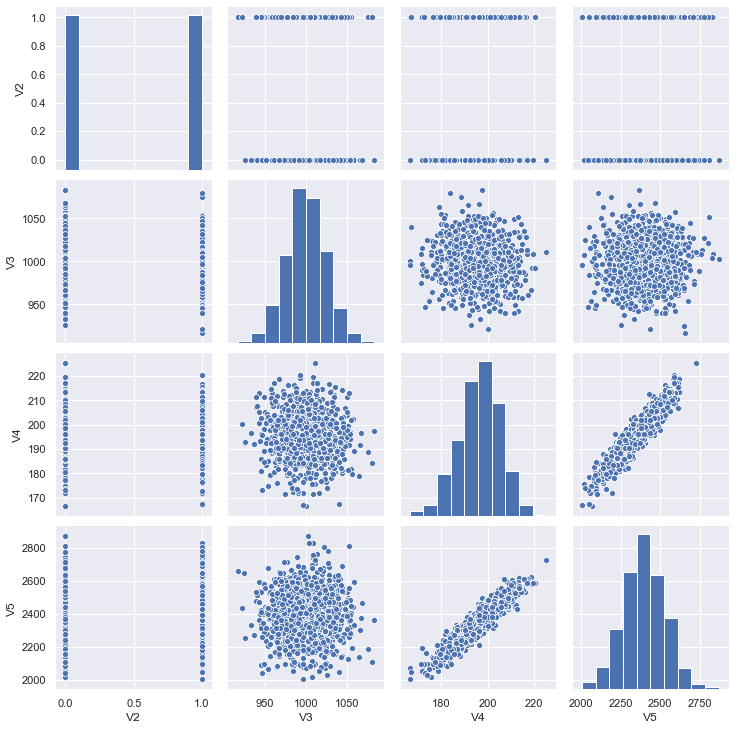

In [7]:
sns.pairplot(data=data)

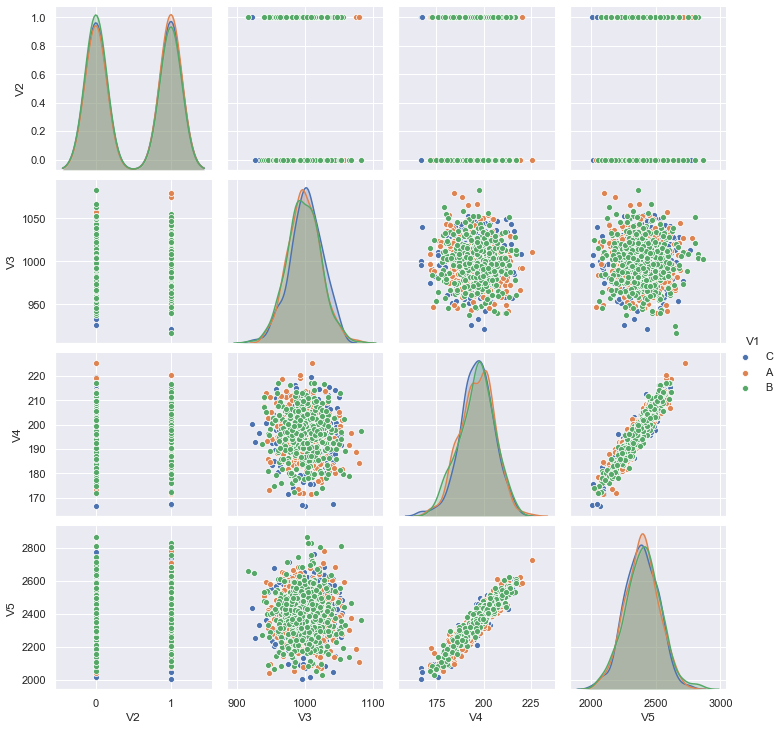

In [8]:
sns.pairplot(data=data, hue= 'V1')

* Los datos son numéricas.
* Sus distribuciones son normales.
* Las columnas V4 y V5 se encuentran correlacionadas entre sí positivamente.

2. Buscaremos decidir el mecanismo que dio origen a los valores faltante de cada columna. Para ello, ten en cuenta que:
* Para simplificar el análisis, si hay valores MAR, la dependencia sólo puede ser con la columna categórica sin valores faltantes, `V1`. Entonces, basta que solamente pruebes dependencia con esa variable. Te puede ser **muy útil** [esta pregunta de Stack Overflow](https://stackoverflow.com/questions/43321455/pandas-count-null-values-in-a-groupby-function/43322220).
* MNAR puede es difícil de estudiar si no tenemos conocimiento del tema o si no hay una variable que correlacione con la variable que queremos estudiar para usar de *proxy*. ¿Qué queremos decir con esto? Imaginate que tienes una planilla con sueldos mensuales de personas y vas a borrar valores con mayor probabilidad si son más altos. Pero no te diste cuenta que en otra planilla figuran el estimativo del sueldo anual, lo cual correlaciona fuertemente con el sueldo mensual. Entonces, si quieres ver si la probabilidad de borrar un valor estaba relacionada con ese valor, lo que puedes hacer es crear intervalos para la variables sin valores faltantes - es decir, crear rangos de sueldos anuales - y contar cuántas instancias que caen dentro de ese intervalo tienen valores faltantes en la variable borrada (sueldo mensual). Al principio es muy confuso, pero piénsalo un rato y vas a ver que tiene sentido.
* MCAR es un mecanismo que puede ser difícil de estudiar. Tal vez es más probable que llegues a él *por descarte* de los otros dos mecanismos.

**MAR con respecto a `V1`**

Dejamos la línea casi completa para el caso de `V2`:

In [9]:
data.V2.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,39
1,B,52
2,C,68


Caso de `V3`:

In [10]:
data.V3.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,30
1,B,0
2,C,74


Caso de `V4`:

In [11]:
data.V4.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,139
1,B,147
2,C,127


Caso de `V5`:

In [12]:
data.V5.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,34
1,B,44
2,C,40


**MNAR**

Las únicas variables correlacionadas son `V4` y `V5`, ambas con valores faltantes. Entonces, podemos usar una para ver si los valores faltantes de la otra son **MNAR**.

Arranquemos estudiando los valores faltantes en `V5`. Para ello, debemos binear `V4` y contar cuántos valores faltantes de `V5` caen en cada intervalo. Entonces, creamos los intervalos para `V4`.

In [13]:
data['V4-intervalos'] = pd.cut(data.V4, bins  = 15)
data

,V1,V2,V3,V4,V5,V4-intervalos
0,C,1.0,986.175237,184.258917,2224.638050,"(182.265, 186.168]"
1,C,1.0,994.130276,NaN,2570.213101,NaN
2,A,1.0,985.782622,196.893581,2309.238832,"(193.974, 197.876]"
3,A,1.0,1029.464887,192.063247,2349.259233,"(190.071, 193.974]"
4,A,1.0,1004.357092,NaN,2474.036357,NaN
...,...,...,...,...,...,...
1495,C,0.0,985.188653,190.366109,2302.000694,"(190.071, 193.974]"
1496,C,0.0,991.730134,193.553401,2277.045998,"(190.071, 193.974]"
1497,B,0.0,1032.150519,NaN,2347.760632,NaN
1498,C,1.0,984.522924,196.373516,2393.847484,"(193.974, 197.876]"


Y contamos cuántas instancias por intervalo tienen valores faltantes en V5.

In [14]:
vf_V4V5 = data.V5.isnull().groupby([data['V4-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V4V5

,V4-intervalos,count
0,"(166.596, 170.557]",0
1,"(170.557, 174.46]",0
2,"(174.46, 178.363]",1
3,"(178.363, 182.265]",2
4,"(182.265, 186.168]",5
5,"(186.168, 190.071]",6
6,"(190.071, 193.974]",17
7,"(193.974, 197.876]",12
8,"(197.876, 201.779]",20
9,"(201.779, 205.682]",13


Pero en realidad lo que nos interesa es la frecuencia de estos valores faltantes, porque no todos los intervalos tienen la misma cantidad de instancias.

In [15]:
vf_V4V5['freq'] = vf_V4V5['count']/data.groupby([data['V4-intervalos']]).count()['V4'].values
vf_V4V5

,V4-intervalos,count,freq
0,"(166.596, 170.557]",0,0.000000
1,"(170.557, 174.46]",0,0.000000
2,"(174.46, 178.363]",1,0.062500
3,"(178.363, 182.265]",2,0.051282
4,"(182.265, 186.168]",5,0.060976
5,"(186.168, 190.071]",6,0.063830
6,"(190.071, 193.974]",17,0.104938
7,"(193.974, 197.876]",12,0.065217
8,"(197.876, 201.779]",20,0.109290
9,"(201.779, 205.682]",13,0.084416


Para que sea más fácil e informativo el gráfico, agregamos a este dataframe el punto medio de cada intervalo.

In [16]:
vf_V4V5["bin_centres"] = vf_V4V5["V4-intervalos"].apply(lambda x: x.mid)
vf_V4V5

,V4-intervalos,count,freq,bin_centres
0,"(166.596, 170.557]",0,0.000000,168.5765
1,"(170.557, 174.46]",0,0.000000,172.5085
2,"(174.46, 178.363]",1,0.062500,176.4115
3,"(178.363, 182.265]",2,0.051282,180.3140
4,"(182.265, 186.168]",5,0.060976,184.2165
5,"(186.168, 190.071]",6,0.063830,188.1195
6,"(190.071, 193.974]",17,0.104938,192.0225
7,"(193.974, 197.876]",12,0.065217,195.9250
8,"(197.876, 201.779]",20,0.109290,199.8275
9,"(201.779, 205.682]",13,0.084416,203.7305


Y finalmente, graficamos

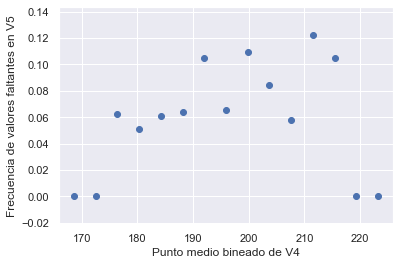

In [17]:
plt.scatter(vf_V4V5['bin_centres'], vf_V4V5['freq'])
plt.xlabel('Punto medio bineado de V4')
plt.ylabel('Frecuencia de valores faltantes en V5')
plt.show()

¿Te parece que da alguna información este gráfico? No te apures a sacar conclusiones. Vuelve a repetir los pasos, pero **invirtiendo el rol de V5 y V4** - solamente tienes que copiar cada celda e intercalar los nombres. Una vez que hayas llegado al gráfico, ahora sí mira si puedes sacar alguna conclusión.

In [18]:
data['V5-intervalos'] = pd.cut(data.V5, bins  = 15)
data

,V1,V2,V3,V4,V5,V4-intervalos,V5-intervalos
0,C,1.0,986.175237,184.258917,2224.638050,"(182.265, 186.168]","(2178.049, 2235.445]"
1,C,1.0,994.130276,NaN,2570.213101,NaN,"(2522.424, 2579.82]"
2,A,1.0,985.782622,196.893581,2309.238832,"(193.974, 197.876]","(2292.841, 2350.236]"
3,A,1.0,1029.464887,192.063247,2349.259233,"(190.071, 193.974]","(2292.841, 2350.236]"
4,A,1.0,1004.357092,NaN,2474.036357,NaN,"(2465.028, 2522.424]"
...,...,...,...,...,...,...,...
1495,C,0.0,985.188653,190.366109,2302.000694,"(190.071, 193.974]","(2292.841, 2350.236]"
1496,C,0.0,991.730134,193.553401,2277.045998,"(190.071, 193.974]","(2235.445, 2292.841]"
1497,B,0.0,1032.150519,NaN,2347.760632,NaN,"(2292.841, 2350.236]"
1498,C,1.0,984.522924,196.373516,2393.847484,"(193.974, 197.876]","(2350.236, 2407.632]"


In [19]:
vf_V5V4 = data.V4.isnull().groupby([data['V5-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V5V4

,V5-intervalos,count
0,"(2005.0, 2063.257]",0
1,"(2063.257, 2120.653]",1
2,"(2120.653, 2178.049]",0
3,"(2178.049, 2235.445]",4
4,"(2235.445, 2292.841]",9
5,"(2292.841, 2350.236]",26
6,"(2350.236, 2407.632]",39
7,"(2407.632, 2465.028]",58
8,"(2465.028, 2522.424]",79
9,"(2522.424, 2579.82]",79


In [20]:
vf_V5V4['freq'] = vf_V5V4['count']/data.groupby([data['V5-intervalos']]).count()['V5'].values
vf_V5V4

,V5-intervalos,count,freq
0,"(2005.0, 2063.257]",0,0.000000
1,"(2063.257, 2120.653]",1,0.040000
2,"(2120.653, 2178.049]",0,0.000000
3,"(2178.049, 2235.445]",4,0.049383
4,"(2235.445, 2292.841]",9,0.058824
5,"(2292.841, 2350.236]",26,0.134715
6,"(2350.236, 2407.632]",39,0.157895
7,"(2407.632, 2465.028]",58,0.254386
8,"(2465.028, 2522.424]",79,0.461988
9,"(2522.424, 2579.82]",79,0.612403


In [21]:
vf_V5V4["bin_centres"] = vf_V5V4["V5-intervalos"].apply(lambda x: x.mid)
vf_V5V4

,V5-intervalos,count,freq,bin_centres
0,"(2005.0, 2063.257]",0,0.000000,2034.1285
1,"(2063.257, 2120.653]",1,0.040000,2091.9550
2,"(2120.653, 2178.049]",0,0.000000,2149.3510
3,"(2178.049, 2235.445]",4,0.049383,2206.7470
4,"(2235.445, 2292.841]",9,0.058824,2264.1430
5,"(2292.841, 2350.236]",26,0.134715,2321.5385
6,"(2350.236, 2407.632]",39,0.157895,2378.9340
7,"(2407.632, 2465.028]",58,0.254386,2436.3300
8,"(2465.028, 2522.424]",79,0.461988,2493.7260
9,"(2522.424, 2579.82]",79,0.612403,2551.1220


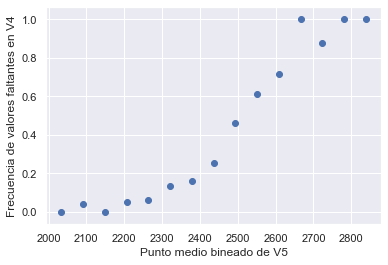

In [22]:
plt.scatter(vf_V5V4['bin_centres'], vf_V5V4['freq'])
plt.xlabel('Punto medio bineado de V5')
plt.ylabel('Frecuencia de valores faltantes en V4')
plt.show()

¿Has llegado a alguna conclusión? Entre V4 y V5, ¿cuál es MNAR y cuál MCAR?¿Y V2?

* V3 es MAR (la probabilidad de valor faltante depende de otra variable-de V1): hay algún tipo de relación entre los valores faltantes de V3 y cada categoría de V1 (en B es 0). Alguna de las categorías está influyendo en la existencia o no de valores faltantes en V3.
* V2 es MCAR.
* V4 es MCAR (el valor faltante es completamente al azar y no depende de otras variables).
* V5 es MNAR (la probabilidad de valor faltante depende de esa misma variable): A medida que crece V5, hay un incremento de valores faltantes en V4.

## 1.2 Imputación de valores faltantes

Vamos a *imputar* los valores faltantes. Te recomendamos que:

1. Al tratarse de un dataset pequeño, puedes copiar el dataset, dejar a un lado el original y rellenar valores faltantes en la copia. De esta forma, podrás evaluar tu estrategia (ver punto siguiente) y/o comparar distintas estrategias.
1. Haz histogramas de las variables con y sin valores faltantes. Al imputar, ¿cambián las distribuciones?¿Esto está bien o mal?

**Ejercicio 1 - Challenge 1:** Comienza con una estrategia sencilla, imputar con el valor medio de cada columna usando Pandas. ¿Para cuáles columnas tendrá sentido esto, teniendo en cuenta lo visto en el punto anterior? 

**Ejercicio 2:** Propone - e implementa - una estrategia que consideres mejor, incorporando la información del punto 1. En el siguiente encuentro, te daremos el dataset sin valores faltantes, por lo que podrás comparar tus resultados. ¡Ten en cuenta que es muy raro que esto se pueda hacer! Lo que nos lleva a...

**Ejercicio 3:** ¿Se te ocurre algún mecanismo de evaluación de tu estrategia? Pista: considera lo que vimos sobre Machine Learning en el Bloque 1 de la carrera. 

Por las dudas, comenzamos volviendo a cargar los datos:

In [23]:
data_2 = pd.read_csv('Data\DS_Bitácora_19_Data_con_VF.csv')

__Ejercicio 1:__

In [24]:
data_2 = data_2.fillna(data_2.mean())

In [25]:
data_2.shape

(1500, 5)

In [26]:
data_2.head()

,V1,V2,V3,V4,V5
0,C,1.0,986.175237,184.258917,2224.638050
1,C,1.0,994.130276,196.414056,2570.213101
2,A,1.0,985.782622,196.893581,2309.238832
3,A,1.0,1029.464887,192.063247,2349.259233
4,A,1.0,1004.357092,196.414056,2474.036357


__Ejercicio 2:__

In [27]:
data_3 = pd.read_csv('Data\DS_Bitácora_19_Data_con_VF.csv')

In [28]:
mean_v2 = data_3['V2'].mean()
print (mean_v2)

0.5003728560775541


In [29]:
data_3['V2'] = data_3['V2'].fillna(mean_v2)
print(data_3['V2'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1495    0.0
1496    0.0
1497    0.0
1498    1.0
1499    0.0
Name: V2, Length: 1500, dtype: float64


In [30]:
mean_v3 = data_3['V3'].mean()
print (mean_v3)

999.6862687520616


In [31]:
data_3['V3'] = data_3['V3'].fillna(mean_v3)
print(data_3['V3'])

0        986.175237
1        994.130276
2        985.782622
3       1029.464887
4       1004.357092
           ...     
1495     985.188653
1496     991.730134
1497    1032.150519
1498     984.522924
1499    1017.399835
Name: V3, Length: 1500, dtype: float64


In [32]:
mean_v5 = data_3['V5'].mean()
print (mean_v5)

2395.781409219903


In [33]:
data_3['V4'] = data_3['V4'].fillna(mean_v5)
print(data_3['V4'])

0        184.258917
1       2395.781409
2        196.893581
3        192.063247
4       2395.781409
           ...     
1495     190.366109
1496     193.553401
1497    2395.781409
1498     196.373516
1499     192.406202
Name: V4, Length: 1500, dtype: float64


In [34]:
data_3['V5'] = data_3['V5'].fillna(mean_v5)
print(data_3['V5'])

0       2224.638050
1       2570.213101
2       2309.238832
3       2349.259233
4       2474.036357
           ...     
1495    2302.000694
1496    2277.045998
1497    2347.760632
1498    2393.847484
1499    2368.906782
Name: V5, Length: 1500, dtype: float64


In [35]:
data_3.head()

,V1,V2,V3,V4,V5
0,C,1.0,986.175237,184.258917,2224.638050
1,C,1.0,994.130276,2395.781409,2570.213101
2,A,1.0,985.782622,196.893581,2309.238832
3,A,1.0,1029.464887,192.063247,2349.259233
4,A,1.0,1004.357092,2395.781409,2474.036357


__Ejercicio 3:__

* Modelo de Regresión, ya que trabajamos con etiquetas numéricas.
* Puede ser de K Vecinos.